# Generate blood vessels with random bezier curves

In [29]:
import matplotlib.pyplot as plt
from vessel_geometry import VesselGeometry
import numpy as np
import torch

In [30]:
size = 256 
# Set a random seed for reproducibility
np.random.seed(42)

# Define the ranges for the parameters
size = 256
n_control_points_range = (2, 15)    # "complexity" of the curves
max_vd_range = (50.0, 150.0)        # Sets the typical curvature of the curves
radius_range = (1, 4)               # Radius of each curve
num_curves_range = (1, 15)          # Number of curves to generate

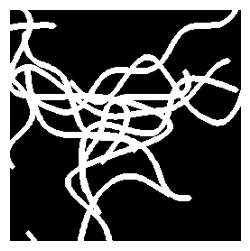

In [31]:
n_control_points = np.random.randint(*n_control_points_range)
max_vd = np.random.uniform(*max_vd_range)
radius = np.random.randint(*radius_range)
num_curves = np.random.randint(*num_curves_range)

vg = VesselGeometry(size, n_control_points, max_vd, radius, num_curves)
img = vg.create_curves()

plt.figure(figsize=(3,3))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


# Vessel Shape Generator

Metadata: {'foreground_texture': 'ILSVRC2012_val_00000015.JPEG', 'background_texture': 'ILSVRC2012_val_00000082.JPEG', 'mask_shape': (256, 256), 'vessel_geometry_params': {'n_control_points': 8, 'max_vd': 129.65429868602328, 'radius': 3, 'num_curves': 11}}


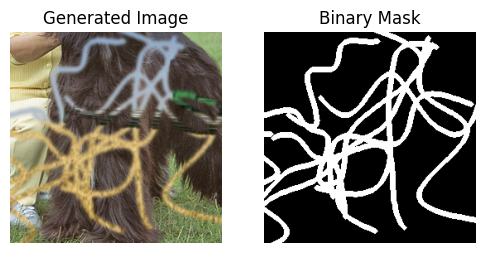

(np.float64(-0.5), np.float64(1023.5), np.float64(255.5), np.float64(-0.5))

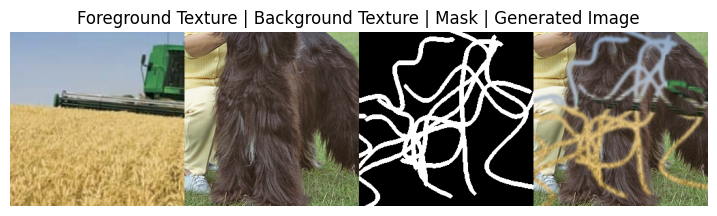

In [2]:
from vessel_shape import VesselShape
import numpy as np
import matplotlib.pyplot as plt


# Define the ranges for the parameters
size = 256
n_control_points_range = (2, 15)    # "complexity" of the curves
max_vd_range = (50.0, 150.0)        # Sets the typical curvature of the curves
radius_range = (1, 4)               # Radius of each curve
num_curves_range = (1, 15)          # Number of curves to generate
sigma = (1, 2)

# Parameters for the dataset
texture_dir = 'imagenet_val_sample'  # Update as needed
annotation_csv = 'imagenet_val_sample/ILSVRC2012_img_val_annotation.csv'

vs = VesselShape(
    image_size=256,
    n_control_points=n_control_points_range,
    max_vd=max_vd_range,
    radius=radius_range,
    num_curves=num_curves_range,
    texture_dir=texture_dir,
    annotation_csv=annotation_csv,
    crop_size=(256, 256),
    sigma=sigma
)

img_blend, mask_bin, metadata, grid = vs.generate_vess_shape(build_grid=True)

print("Metadata:", metadata)

# plot the generated image
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.title('Generated Image')
plt.imshow(img_blend, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Binary Mask')
plt.imshow(mask_bin, cmap='gray')
plt.axis('off')
plt.show()

# Plot grid
plt.figure(figsize=(9, 6))
plt.title('Foreground Texture | Background Texture | Mask | Generated Image')
plt.imshow(grid, cmap='gray')
plt.axis('off')



# Vessel Shape as Torch Dataset

In [3]:
from vessel_shape import VesselShapeDataset
from vessel_shape import VesselShape
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Define the ranges for the parameters
size = 256
n_control_points_range = (2, 15)    # "complexity" of the curves
max_vd_range = (50.0, 150.0)        # Sets the typical curvature of the curves
radius_range = (1, 4)               # Radius of each curve
num_curves_range = (1, 15)          # Number of curves to generate
sigma = (1, 2)

# Parameters for the dataset
texture_dir = 'imagenet_val_sample'  # Update as needed
annotation_csv = 'imagenet_val_sample/ILSVRC2012_img_val_annotation.csv'


# Instancie o gerador
vessel_shape_gen = VesselShape(
    image_size=256,
    n_control_points=n_control_points_range,
    max_vd=max_vd_range,
    radius=radius_range,
    num_curves=num_curves_range,
    texture_dir=texture_dir,
    annotation_csv=annotation_csv,
    crop_size=(256, 256),
    sigma=sigma
)

# Passe o gerador para o Dataset
ds_runtime = VesselShapeDataset(vessel_shape_gen, n_samples=10, gray_scale=True)

# DataLoader PyTorch
dataloader = DataLoader(ds_runtime, batch_size=5, shuffle=True)

In [4]:
# Cria o iterador
dataloader_iter = iter(dataloader)

# Pega o próximo batch
batch_imgs, batch_masks, batch_meta = next(dataloader_iter)

# Agora você pode acessar os elementos normalmente
print("Batch length:", len(batch_imgs))
print(batch_imgs.shape)
print(batch_masks.shape)
print("Mask min and max values:", batch_masks[0].min(), batch_masks[0].max())
print(batch_meta)

Batch length: 5
torch.Size([5, 1, 256, 256])
torch.Size([5, 1, 256, 256])
Mask min and max values: tensor(0.) tensor(1.)
{'foreground_texture': ['ILSVRC2012_val_00000076.JPEG', 'ILSVRC2012_val_00000014.JPEG', 'ILSVRC2012_val_00000024.JPEG', 'ILSVRC2012_val_00000058.JPEG', 'ILSVRC2012_val_00000099.JPEG'], 'background_texture': ['ILSVRC2012_val_00000043.JPEG', 'ILSVRC2012_val_00000073.JPEG', 'ILSVRC2012_val_00000072.JPEG', 'ILSVRC2012_val_00000066.JPEG', 'ILSVRC2012_val_00000084.JPEG'], 'mask_shape': [tensor([256, 256, 256, 256, 256]), tensor([256, 256, 256, 256, 256])], 'vessel_geometry_params': {'n_control_points': tensor([8, 5, 4, 4, 6]), 'max_vd': tensor([126.1620, 144.0523,  87.2283, 126.8554,  89.8505], dtype=torch.float64), 'radius': tensor([3, 3, 1, 1, 2]), 'num_curves': tensor([ 1,  2,  3, 12,  6])}}


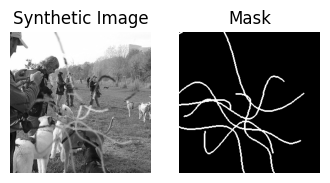

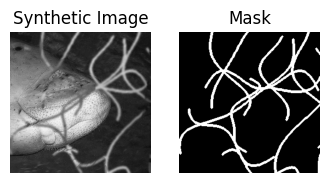

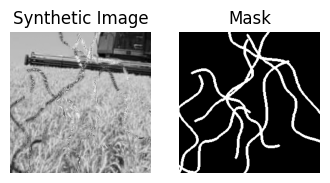

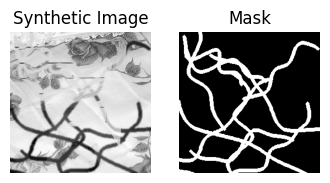

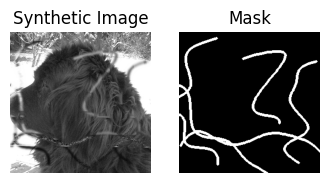

In [5]:
for batch_imgs, batch_masks, _ in dataloader:
    # Visualizando o primeiro batch
    for i in range(batch_imgs.shape[0]):
        img_np = (batch_imgs[i].permute(1,2,0).numpy() * 255).astype('uint8')
        mask_np = (batch_masks[i][0].numpy() * 255).astype('uint8')
        plt.figure(figsize=(4,2))
        plt.subplot(1,2,1)
        plt.imshow(img_np, cmap='gray')
        plt.title('Synthetic Image')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(mask_np, cmap='gray')
        plt.title('Mask')
        plt.axis('off')
    break

## Treinando a UNet pequena com o dataset sintético gerado em runtime e plotando curvas

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from vessel_shape import VesselShape, VesselShapeDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
# Modelo
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNetSmall(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(64, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv(64, 32)
        self.final = nn.Conv2d(32, out_channels, 1)
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        up2 = self.up2(bottleneck)
        dec2 = self.dec2(torch.cat([up2, enc2], dim=1))
        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, enc1], dim=1))
        return self.final(dec1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetSmall(in_channels=1, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:


# Define os ranges dos parâmetros
size = 256
n_control_points_range = (2, 15)    # Complexidade das curvas
max_vd_range = (50.0, 150.0)        # Curvatura típica das curvas
radius_range = (1, 4)               # Raio de cada curva
num_curves_range = (1, 15)          # Número de curvas
sigma = (1, 2)

# Parâmetros do dataset
texture_dir = 'imagenet_val_sample'
annotation_csv = 'imagenet_val_sample/ILSVRC2012_img_val_annotation.csv'

# Instanciando os geradores com ranges
vessel_shape_gen_train = VesselShape(
    image_size=size,
    n_control_points=n_control_points_range,
    max_vd=max_vd_range,
    radius=radius_range,
    num_curves=num_curves_range,
    texture_dir=texture_dir,
    annotation_csv=annotation_csv,
    crop_size=(size, size),
    sigma=sigma
)
vessel_shape_gen_valid = VesselShape(
    image_size=size,
    n_control_points=n_control_points_range,
    max_vd=max_vd_range,
    radius=radius_range,
    num_curves=num_curves_range,
    texture_dir=texture_dir,
    annotation_csv=annotation_csv,
    crop_size=(size, size),
    sigma=sigma
)

# Datasets PyTorch
train_dataset = VesselShapeDataset(vessel_shape_gen_train, n_samples=1000, gray_scale=True)
valid_dataset = VesselShapeDataset(vessel_shape_gen_valid, n_samples=16, gray_scale=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)



def batch_iou(preds, targets, threshold=0.5, eps=1e-7):
    preds = (torch.sigmoid(preds) > threshold).float()
    targets = (targets > 0.5).float()
    intersection = (preds * targets).sum(dim=[1,2,3])
    union = ((preds + targets) > 0).float().sum(dim=[1,2,3])
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/{n_epochs}')
    model.train()
    train_loss = 0.0
    train_iou = 0.0
    for imgs, masks, _ in tqdm(train_loader, desc=f'Treino Época {epoch+1}'):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        train_iou += batch_iou(outputs, masks) * imgs.size(0)
    train_loss /= len(train_loader.dataset)
    train_iou /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_iou)
    print(f'Train loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}')

    model.eval()
    valid_loss = 0.0
    valid_iou = 0.0
    with torch.no_grad():
        for batch_idx, (imgs, masks, _) in enumerate(tqdm(valid_loader, desc=f'Validação Época {epoch+1}')):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            valid_loss += loss.item() * imgs.size(0)
            valid_iou += batch_iou(outputs, masks) * imgs.size(0)

            # Plote o primeiro batch de cada época
            if batch_idx == 0:
                preds = torch.sigmoid(outputs) > 0.5
                for i in range(min(1, imgs.shape[0])):  # Plote até 4 exemplos
                    img_np = imgs[i][0].cpu().numpy()  # [0, H, W] para gray_scale
                    mask_np = masks[i][0].cpu().numpy()
                    pred_np = preds[i][0].cpu().numpy()
                    plt.figure(figsize=(8,2))
                    plt.subplot(1,3,1)
                    plt.imshow(img_np, cmap='gray')
                    plt.title('Imagem')
                    plt.axis('off')
                    plt.subplot(1,3,2)
                    plt.imshow(mask_np, cmap='gray')
                    plt.title('Máscara Real')
                    plt.axis('off')
                    plt.subplot(1,3,3)
                    plt.imshow(pred_np, cmap='gray')
                    plt.title('Predição')
                    plt.axis('off')
                    plt.show()
    valid_loss /= len(valid_loader.dataset)
    valid_iou /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_iou)
    print(f'Valid loss: {valid_loss:.4f} | Valid IoU: {valid_iou:.4f}')

# Plotando curvas de loss e IoU
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss por época')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train IoU')
plt.plot(valid_accs, label='Valid IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('IoU por época')
plt.show()

## Testando o modelo treinado em novas imagens sintéticas

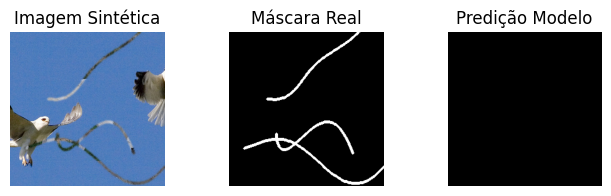

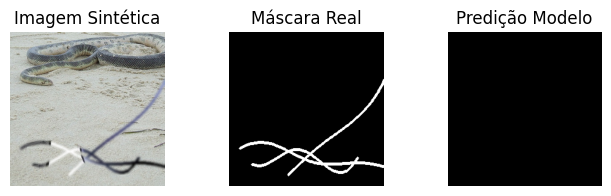

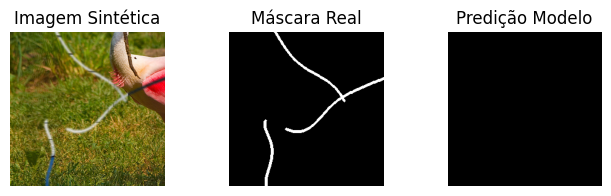

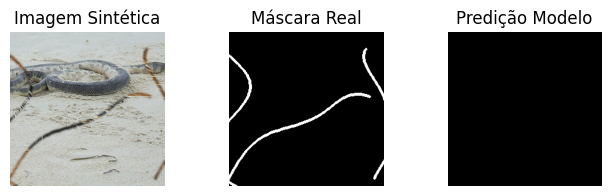

In [26]:
# Gerando novas imagens sintéticas para teste
ds_test = VesselShape(
    image_size=256, n_control_points=5, max_vd=80, radius=2, num_curves=3,
    texture_dir=texture_dir, annotation_csv=annotation_csv, crop_size=(256, 256), n_samples=4
)
test_dataset = VesselShapeTorchDataset(ds_test)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

ds_test.reset_epoch()
model.eval()
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.sigmoid(outputs) > 0.5
        for i in range(imgs.shape[0]):
            img_np = (imgs[i].cpu().permute(1,2,0).numpy() * 255).astype('uint8')
            mask_np = (masks[i][0].cpu().numpy() * 255).astype('uint8')
            pred_np = (preds[i][0].cpu().numpy() * 255).astype('uint8')
            plt.figure(figsize=(8,2))
            plt.subplot(1,3,1)
            plt.imshow(img_np)
            plt.title('Imagem Sintética')
            plt.axis('off')
            plt.subplot(1,3,2)
            plt.imshow(mask_np, cmap='gray')
            plt.title('Máscara Real')
            plt.axis('off')
            plt.subplot(1,3,3)
            plt.imshow(pred_np, cmap='gray')
            plt.title('Predição Modelo')
            plt.axis('off')
            plt.show()